In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from itertools import combinations
from matplotlib import cm
from lightgbm import LGBMClassifier
import shap
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Load your data
earthquake_data = pd.read_csv("/Users/andrewsebastian/Downloads/earthquake.csv")

# Display the data table
earthquake_data

Date      Time  Latitude  Longitude        Type   Depth  \
0      01/02/1965  13:44:18   19.2460   145.6160  Earthquake  131.60   
1      01/04/1965  11:29:49    1.8630   127.3520  Earthquake   80.00   
2      01/05/1965  18:05:58  -20.5790  -173.9720  Earthquake   20.00   
3      01/08/1965  18:49:43  -59.0760   -23.5570  Earthquake   15.00   
4      01/09/1965  13:32:50   11.9380   126.4270  Earthquake   15.00   
...           ...       ...       ...        ...         ...     ...   
23407  12/28/2016  08:22:12   38.3917  -118.8941  Earthquake   12.30   
23408  12/28/2016  09:13:47   38.3777  -118.8957  Earthquake    8.80   
23409  12/28/2016  12:38:51   36.9179   140.4262  Earthquake   10.00   
23410  12/29/2016  22:30:19   -9.0283   118.6639  Earthquake   79.00   
23411  12/30/2016  20:08:28   37.3973   141.4103  Earthquake   11.94   

       Depth Error  Depth Seismic Stations  Magnitude Magnitude Type  ...  \
0              NaN                     NaN        6.0             MW  ...   
1              NaN                     NaN        5.8             MW  ...   
2              NaN                     NaN        6.2             MW  ...   
3              NaN                     NaN        5.8             MW  ...   
4              NaN                     NaN        5.8             MW  ...   
...            ...                     ...        ...            ...  ...   
23407          1.2                    40.0        5.6             ML  ...   
23408          2.0                    33.0        5.5             ML  ...   
23409          1.8                     NaN        5.9            MWW  ...   
23410          1.8                     NaN        6.3            MWW  ...   
23411          2.2                     NaN        5.5             MB  ...   

       Magnitude Seismic Stations  Azimuthal Gap  Horizontal Distance  \
0                             NaN            NaN                  NaN   
1                             NaN            NaN                  NaN   
2                             NaN            NaN                  NaN   
3                             NaN            NaN                  NaN   
4                             NaN            NaN                  NaN   
...                           ...            ...                  ...   
23407                        18.0          42.47                0.120   
23408                        18.0          48.58                0.129   
23409                         NaN          91.00                0.992   
23410                         NaN          26.00                3.553   
23411                       428.0          97.00                0.681   

       Horizontal Error  Root Mean Square            ID  Source  \
0                   NaN               NaN  ISCGEM860706  ISCGEM   
1                   NaN               NaN  ISCGEM860737  ISCGEM   
2                   NaN               NaN  ISCGEM860762  ISCGEM   
3                   NaN               NaN  ISCGEM860856  ISCGEM   
4                   NaN               NaN  ISCGEM860890  ISCGEM   
...                 ...               ...           ...     ...   
23407               NaN            0.1898    NN00570710      NN   
23408               NaN            0.2187    NN00570744      NN   
23409               4.8            1.5200    US10007NAF      US   
23410               6.0            1.4300    US10007NL0      US   
23411               4.5            0.9100    US10007NTD      US   

      Location Source Magnitude Source     Status  
0              ISCGEM           ISCGEM  Automatic  
1              ISCGEM           ISCGEM  Automatic  
2              ISCGEM           ISCGEM  Automatic  
3              ISCGEM           ISCGEM  Automatic  
4              ISCGEM           ISCGEM  Automatic  
...               ...              ...        ...  
23407              NN               NN   Reviewed  
23408              NN               NN   Reviewed  
23409              US               US   Reviewed  
23410              US

In [3]:
earthquake_data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [4]:
earthquake_data = earthquake_data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
earthquake_data.head()

Date      Time  Latitude  Longitude  Depth  Magnitude
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8

In [5]:
# Extract timestamps
timestamp = []
for date, time in zip(earthquake_data['Date'], earthquake_data['Time']):
    try:
         # Convert date and time to timestamp
        ts = datetime.datetime.strptime(date + ' ' + time, '%m/%d/%Y %H:%M:%S')
        timestamp.append(ts.timestamp())
    except ValueError:
        # Handle cases where the date or time format is incorrect
        timestamp.append('ValueError')

In [6]:
# Add timestamps to the DataFrame
earthquake_data['Timestamp'] = pd.to_numeric(pd.Series(timestamp), errors='coerce')

# Remove rows with 'ValueError' in the Timestamp column
earthquake_data = earthquake_data[earthquake_data.Timestamp != 'ValueError']
earthquake_data

/var/folders/j7/_x3ybjp15wdgc3b5zsx2kfn40000gn/T/ipykernel_95600/3216060777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquake_data['Timestamp'] = pd.to_numeric(pd.Series(timestamp), errors='coerce')


Date      Time  Latitude  Longitude   Depth  Magnitude  \
0      01/02/1965  13:44:18   19.2460   145.6160  131.60        6.0   
1      01/04/1965  11:29:49    1.8630   127.3520   80.00        5.8   
2      01/05/1965  18:05:58  -20.5790  -173.9720   20.00        6.2   
3      01/08/1965  18:49:43  -59.0760   -23.5570   15.00        5.8   
4      01/09/1965  13:32:50   11.9380   126.4270   15.00        5.8   
...           ...       ...       ...        ...     ...        ...   
23407  12/28/2016  08:22:12   38.3917  -118.8941   12.30        5.6   
23408  12/28/2016  09:13:47   38.3777  -118.8957    8.80        5.5   
23409  12/28/2016  12:38:51   36.9179   140.4262   10.00        5.9   
23410  12/29/2016  22:30:19   -9.0283   118.6639   79.00        6.3   
23411  12/30/2016  20:08:28   37.3973   141.4103   11.94        5.5   

          Timestamp  
0     -1.576557e+08  
1     -1.574910e+08  
2     -1.573808e+08  
3     -1.571190e+08  
4     -1.570516e+08  
...             ...  
23407  1.482888e+09  
23408  1.482891e+09  
23409  1.482904e+09  
23410  1.483025e+09  
23411  1.483103e+09  

[23412 rows x 7 columns]

In [7]:
# Determine Location_Type for earthquake data
def determine_location_type(latitude, longitude):
    if latitude < 0:
        return 'Oceanic'
    else:
        return 'Continental'

earthquake_data['Location Type'] = earthquake_data.apply(lambda row: determine_location_type(row['Latitude'], row['Longitude']), axis=1)

# Display the earthquake data with Location_Type
earthquake_data.head()

#Our simple yet effective logic here is to classify any earthquake with a latitude less than zero as 'Oceanic', 
#implying it occurred in the southern hemisphere, predominantly covered by oceanic waters. Conversely, if the latitude is zero or greater, 
#we label it as 'Continental', suggesting it occurred on land in the northern hemisphere.

Date      Time  Latitude  Longitude  Depth  Magnitude    Timestamp  \
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0 -157655742.0   
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8 -157491011.0   
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2 -157380842.0   
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8 -157119017.0   
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8 -157051630.0   

  Location Type  
0   Continental  
1   Continental  
2       Oceanic  
3       Oceanic  
4   Continental

In [8]:
# Determine Magnitude Type based on your criteria (replace 'YourMagnitudeTypeLogic' with your actual logic)
def determine_magnitude_type(magnitude):
    if magnitude < 5:
        return 'Low'
    elif 5 <= magnitude < 7:
        return 'Medium'
    else:
        return 'High'

# Apply the magnitude type function to create a new column
earthquake_data['Magnitude Type'] = earthquake_data['Magnitude'].apply(determine_magnitude_type)
earthquake_data.head()

Date      Time  Latitude  Longitude  Depth  Magnitude    Timestamp  \
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0 -157655742.0   
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8 -157491011.0   
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2 -157380842.0   
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8 -157119017.0   
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8 -157051630.0   

  Location Type Magnitude Type  
0   Continental         Medium  
1   Continental         Medium  
2       Oceanic         Medium  
3       Oceanic         Medium  
4   Continental         Medium

In [9]:
# Logic to determine earthquake type based on columns like 'Depth', 'Magnitude'
def determine_earthquake_type(row):
    
    if row['Depth'] < 50 and row['Magnitude'] >= 5:
        return 'Tectonic'
    elif row['Depth'] >= 50 and row['Magnitude'] >= 6:
        return 'Volcanic'
    else:
        return 'Anthropogenic'  # You can customize these conditions based on your dataset

# Apply the earthquake type function to create a new column
earthquake_data['Earthquake Type'] = earthquake_data.apply(determine_earthquake_type, axis=1)
earthquake_data.head()

Date      Time  Latitude  Longitude  Depth  Magnitude    Timestamp  \
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0 -157655742.0   
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8 -157491011.0   
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2 -157380842.0   
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8 -157119017.0   
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8 -157051630.0   

  Location Type Magnitude Type Earthquake Type  
0   Continental         Medium        Volcanic  
1   Continental         Medium   Anthropogenic  
2       Oceanic         Medium        Tectonic  
3       Oceanic         Medium        Tectonic  
4   Continental         Medium        Tectonic

In [10]:
# Assuming 'Time' column has a format like '%H:%M:%S'
# Add real-time date to the 'Time' column
earthquake_data['Time'] = pd.to_datetime(earthquake_data['Time'], format='%H:%M:%S', errors='coerce')

# Add Time of Day or Season column
def determine_time_of_day_or_season(row):
    if pd.notna(row['Time']):
        hour = row['Time'].hour
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Evening/Night'
    else:
        return np.nan

# Apply the time of day or season function to create a new column
earthquake_data['Time of Day or Season'] = earthquake_data.apply(determine_time_of_day_or_season, axis=1)
earthquake_data['Time'] = earthquake_data['Time'].dt.time  # Extract only the time component

# Display the cleaned and transformed data
earthquake_data.head()

Date      Time  Latitude  Longitude  Depth  Magnitude    Timestamp  \
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0 -157655742.0   
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8 -157491011.0   
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2 -157380842.0   
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8 -157119017.0   
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8 -157051630.0   

  Location Type Magnitude Type Earthquake Type Time of Day or Season  
0   Continental         Medium        Volcanic             Afternoon  
1   Continental         Medium   Anthropogenic               Morning  
2       Oceanic         Medium        Tectonic         Evening/Night  
3       Oceanic         Medium        Tectonic         Evening/Night  
4   Continental         Medium        Tectonic             Afternoon

In [60]:
# Supervised Learning Models (SVM and Decision Tree)
# X contains features and y contains the target variable
X = earthquake_data[['Longitude', 'Latitude', 'Depth']]
y = earthquake_data['Earthquake Type']

In [61]:
# Encode the target variable for XGBoost
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data for XGBoost only
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Split the data for LightGBM only
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y_encoded, test_size=0.2, random_state=42) # Calculate class weights for balancing

In [65]:
# Calculate class weights for balancing
class_weights = y.value_counts().max() / y.value_counts()
weights = y.map(class_weights)
class_weights_encoded = pd.Series(y_encoded).value_counts().max() / pd.Series(y_encoded).value_counts()
weights_encoded = pd.Series(y_encoded).map(class_weights_encoded).loc[X_train_xgb.index]

In [113]:
# SVM Model Training
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [67]:
# Decision Tree Model Training
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [68]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
# Train XGBoost model with weights
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train_xgb, y_train_xgb, sample_weight=weights_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [82]:
# Prepare the dataset for LightGBM
# Initialize an LGBMClassifier
lgb_classifier = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(np.unique(y_train_lgb)),
    metric='multi_logloss',
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    max_bin=255,
    subsample=0.6,
    subsample_freq=0,
    colsample_bytree=0.7,
    min_child_weight=0.001,
    min_split_gain=0.5,
    n_estimators=100,
    random_state=42
)

# Fit the model
lgb_classifier.fit(X_train_lgb, y_train_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18729, number of used features: 3
[LightGBM] [Info] Start training from score -1.671328
[LightGBM] [Info] Start training from score -0.309762
[LightGBM] [Info] Start training from score -2.546172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

LGBMClassifier(colsample_bytree=0.7, max_bin=255, metric='multi_logloss',
               min_split_gain=0.5, num_class=3, objective='multiclass',
               random_state=42, subsample=0.6)

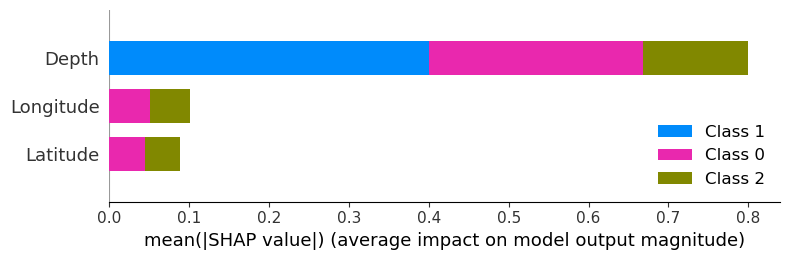

In [174]:
# Compute SHAP values for the Decision Tree model
explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

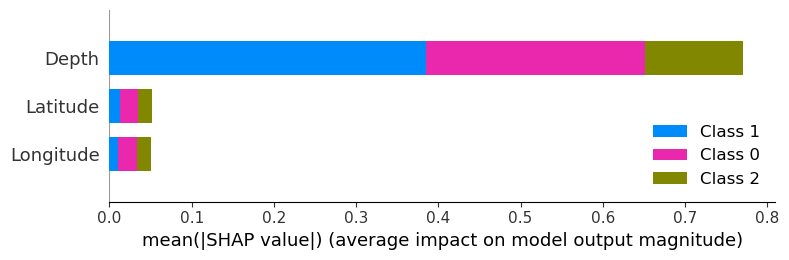

In [116]:
# Compute SHAP values for the Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

[23:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


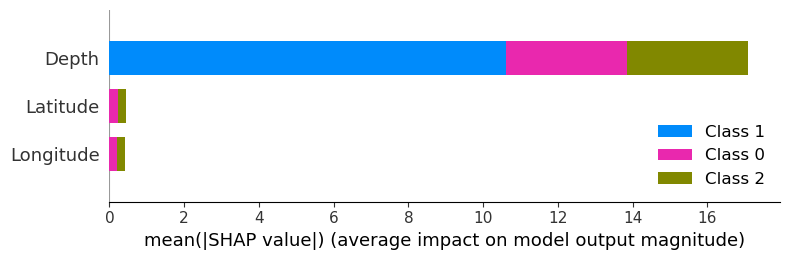

In [117]:
# Compute SHAP values for the XGBoost model
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

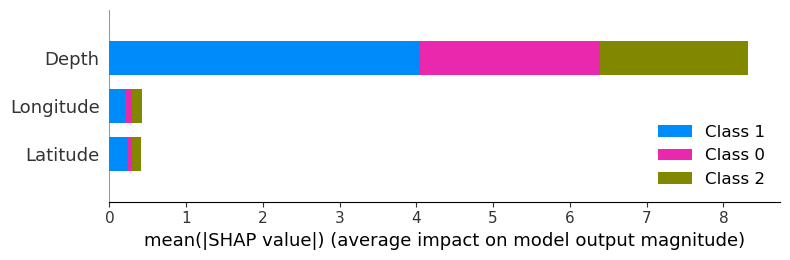

In [118]:
# Compute SHAP values for the LightGBM model
explainer_lgb = shap.TreeExplainer(lgb_classifier)
shap_values_lgb = explainer_lgb.shap_values(X_test)
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar")

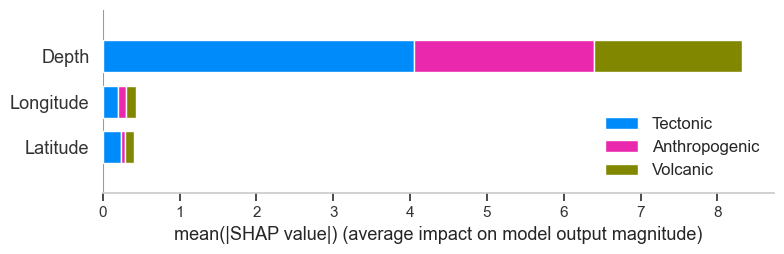

In [196]:
# Compute SHAP values for the LightGBM model
explainer_lgb = shap.TreeExplainer(lgb_classifier)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Turn off the grid display
plt.rcParams["axes.grid"] = False

# Create a summary bar plot of SHAP values for each feature across all samples
# Make sure to replace 'le.classes_' with your actual class names if necessary
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar", class_names=le.classes_)


  0%|          | 0/4683 [00:00<?, ?it/s]

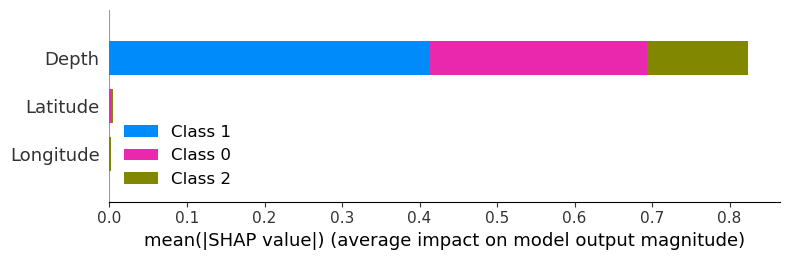

In [120]:
# Assuming svm_model is a trained SVM model with probability=True
# Sample a background distribution from the training dataset
background_data = shap.sample(X_train, 100)

# Define the SVM predictor function that outputs probability estimates
# Note: predict_proba is used because KernelExplainer requires raw probability outputs
svm_predictor = svm_model.predict_proba

# Initialize the SHAP KernelExplainer with the SVM predictor and the background data
explainer_svm = shap.KernelExplainer(svm_predictor, background_data)

# Compute SHAP values for the test set
shap_values_svm = explainer_svm.shap_values(X_test)

# Create a summary bar plot of SHAP values for each feature across all samples
shap.summary_plot(shap_values_svm, X_test, plot_type="bar")

In [121]:
# Make Predictions and Evaluate the Model for XGBoost
y_pred_xgb = model_xgb.predict(X_test_xgb)
accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
report_xgb = classification_report(y_test_xgb, y_pred_xgb, target_names=le.classes_)

print("XGBoost Model Accuracy: ", accuracy_xgb)
print("---------------------------------------------")
print("XGBoost Confusion Matrix: \n", conf_matrix_xgb)
print("---------------------------------------------")
print("XGBoost Classification Report: \n", report_xgb)

XGBoost Model Accuracy:  0.8802049967969251
---------------------------------------------
XGBoost Confusion Matrix: 
 [[ 624    0  325]
 [   0 3345    0]
 [ 236    0  153]]
---------------------------------------------
XGBoost Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.73      0.66      0.69       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.32      0.39      0.35       389

     accuracy                           0.88      4683
    macro avg       0.68      0.68      0.68      4683
 weighted avg       0.89      0.88      0.88      4683



In [186]:
# XGBoost Model Evaluation
xgb_micro_precision = precision_score(y_test_xgb, y_pred_xgb, average='micro')
xgb_micro_recall = recall_score(y_test_xgb, y_pred_xgb, average='micro')
xgb_micro_f1 = f1_score(y_test_xgb, y_pred_xgb, average='micro')

xgb_macro_precision = precision_score(y_test_xgb, y_pred_xgb, average='macro')
xgb_macro_recall = recall_score(y_test_xgb, y_pred_xgb, average='macro')
xgb_macro_f1 = f1_score(y_test_xgb, y_pred_xgb, average='macro')

print("XGBoost Model Micro-average Precision: ", xgb_micro_precision)
print("XGBoost Model Micro-average Recall: ", xgb_micro_recall)
print("XGBoost Model Micro-average F1 Score: ", xgb_micro_f1)
print("---------------------------------------------")
print("XGBoost Model Macro-average Precision: ", xgb_macro_precision)
print("XGBoost Model Macro-average Recall: ", xgb_macro_recall)
print("XGBoost Model Macro-average F1 Score: ", xgb_macro_f1)

XGBoost Model Micro-average Precision:  0.8802049967969251
XGBoost Model Micro-average Recall:  0.8802049967969251
XGBoost Model Micro-average F1 Score:  0.8802049967969251
---------------------------------------------
XGBoost Model Macro-average Precision:  0.6818883591190685
XGBoost Model Macro-average Recall:  0.6836168139826976
XGBoost Model Macro-average F1 Score:  0.680941696745033


In [122]:
# Predictions using the SVM model
svm_predictions = svm_model.predict(X_test)
# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)
# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, svm_predictions)
# Classification Report
report_svm = classification_report(y_test, svm_predictions, target_names=le.classes_)

print("SVM Model Accuracy: ", svm_accuracy)
print("---------------------------------------------")
print("SVM Confusion Matrix: \n", conf_matrix_svm)
print("---------------------------------------------")
print("SVM Classification Report: \n", report_svm)

SVM Model Accuracy:  0.9165065129190689
---------------------------------------------
SVM Confusion Matrix: 
 [[ 949    0    0]
 [   2 3343    0]
 [ 389    0    0]]
---------------------------------------------
SVM Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.71      1.00      0.83       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.00      0.00      0.00       389

     accuracy                           0.92      4683
    macro avg       0.57      0.67      0.61      4683
 weighted avg       0.86      0.92      0.88      4683



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [187]:
# Replace 'y_test' with your actual test labels and 'svm_predictions' with the predictions from your SVM model
svm_micro_precision = precision_score(y_test, svm_predictions, average='micro')
svm_micro_recall = recall_score(y_test, svm_predictions, average='micro')
svm_micro_f1 = f1_score(y_test, svm_predictions, average='micro')

svm_macro_precision = precision_score(y_test, svm_predictions, average='macro')
svm_macro_recall = recall_score(y_test, svm_predictions, average='macro')
svm_macro_f1 = f1_score(y_test, svm_predictions, average='macro')

print(f"SVM Model Micro-average Precision: {svm_micro_precision}")
print(f"SVM Model Micro-average Recall: {svm_micro_recall}")
print(f"SVM Model Micro-average F1 Score: {svm_micro_f1}")
print("---------------------------------------------")
print(f"SVM Model Macro-average Precision: {svm_macro_precision}")
print(f"SVM Model Macro-average Recall: {svm_macro_recall}")
print(f"SVM Model Macro-average F1 Score: {svm_macro_f1}")

SVM Model Micro-average Precision: 0.9165065129190689
SVM Model Micro-average Recall: 0.9165065129190689
SVM Model Micro-average F1 Score: 0.9165065129190689
---------------------------------------------
SVM Model Macro-average Precision: 0.5694029850746268
SVM Model Macro-average Recall: 0.6664673642252118
SVM Model Macro-average F1 Score: 0.609628002101445


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [92]:
# Predictions using the Decision Tree model
dt_predictions = dt_model.predict(X_test)
# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions)
# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, dt_predictions)
# Classification Report
report_dt = classification_report(y_test, dt_predictions, target_names=le.classes_)

print("Decision Tree Model Accuracy: ", dt_accuracy)
print("---------------------------------------------")
print("Decision Tree Confusion Matrix: \n", conf_matrix_dt)
print("---------------------------------------------")
print("Decision Tree Classification Report: \n", report_dt)

Decision Tree Model Accuracy:  0.8763613068545804
---------------------------------------------
Decision Tree Confusion Matrix: 
 [[ 636    0  313]
 [   0 3345    0]
 [ 266    0  123]]
---------------------------------------------
Decision Tree Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.71      0.67      0.69       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.28      0.32      0.30       389

     accuracy                           0.88      4683
    macro avg       0.66      0.66      0.66      4683
 weighted avg       0.88      0.88      0.88      4683



In [188]:
# Assuming y_test and dt_predictions are already defined in your environment.
# Calculate micro-average metrics
dt_micro_precision = precision_score(y_test, dt_predictions, average='micro')
dt_micro_recall = recall_score(y_test, dt_predictions, average='micro')
dt_micro_f1 = f1_score(y_test, dt_predictions, average='micro')

# Calculate macro-average metrics
dt_macro_precision = precision_score(y_test, dt_predictions, average='macro')
dt_macro_recall = recall_score(y_test, dt_predictions, average='macro')
dt_macro_f1 = f1_score(y_test, dt_predictions, average='macro')

print("Decision Tree Model Micro-average Precision: ", dt_micro_precision)
print("Decision Tree Model Micro-average Recall: ", dt_micro_recall)
print("Decision Tree Model Micro-average F1 Score: ", dt_micro_f1)
print("---------------------------------------------")
print("Decision Tree Model Macro-average Precision: ", dt_macro_precision)
print("Decision Tree Model Macro-average Recall: ", dt_macro_recall)
print("Decision Tree Model Macro-average F1 Score: ", dt_macro_f1)

Decision Tree Model Micro-average Precision:  0.8763613068545804
Decision Tree Model Micro-average Recall:  0.8763613068545804
Decision Tree Model Micro-average F1 Score:  0.8763613068545804
---------------------------------------------
Decision Tree Model Macro-average Precision:  0.662403290004543
Decision Tree Model Macro-average Recall:  0.6621248362277344
Decision Tree Model Macro-average F1 Score:  0.661792642797505


In [149]:
# Predictions using the Random Forest model
rf_predictions = rf_model.predict(X_test)
# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
# Classification Report
report_rf = classification_report(y_test, rf_predictions, target_names=le.classes_)

print("Random Forest Model Accuracy: ", rf_accuracy)
print("---------------------------------------------")
print("Random Forest Confusion Matrix: \n", conf_matrix_rf)
print("---------------------------------------------")
print("Random Forest Classification Report: \n", report_rf)

Random Forest Model Accuracy:  0.904975443092035
---------------------------------------------
Random Forest Confusion Matrix: 
 [[ 819    0  130]
 [   0 3345    0]
 [ 315    0   74]]
---------------------------------------------
Random Forest Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.72      0.86      0.79       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.36      0.19      0.25       389

     accuracy                           0.90      4683
    macro avg       0.69      0.68      0.68      4683
 weighted avg       0.89      0.90      0.89      4683



In [189]:
# Make predictions using the Random Forest model
rf_predictions = rf_model.predict(X_test)

# Calculate micro-average metrics for Random Forest Model
rf_micro_precision = precision_score(y_test, rf_predictions, average='micro')
rf_micro_recall = recall_score(y_test, rf_predictions, average='micro')
rf_micro_f1 = f1_score(y_test, rf_predictions, average='micro')

# Calculate macro-average metrics for Random Forest Model
rf_macro_precision = precision_score(y_test, rf_predictions, average='macro')
rf_macro_recall = recall_score(y_test, rf_predictions, average='macro')
rf_macro_f1 = f1_score(y_test, rf_predictions, average='macro')

print("Random Forest Model Micro-average Precision: ", rf_micro_precision)
print("Random Forest Model Micro-average Recall: ", rf_micro_recall)
print("Random Forest Model Micro-average F1 Score: ", rf_micro_f1)
print("---------------------------------------------")
print("Random Forest Model Macro-average Precision: ", rf_macro_precision)
print("Random Forest Model Macro-average Recall: ", rf_macro_recall)
print("Random Forest Model Macro-average F1 Score: ", rf_macro_f1)

Random Forest Model Micro-average Precision:  0.904975443092035
Random Forest Model Micro-average Recall:  0.904975443092035
Random Forest Model Micro-average F1 Score:  0.904975443092035
---------------------------------------------
Random Forest Model Macro-average Precision:  0.6949891067538126
Random Forest Model Macro-average Recall:  0.684415020366001
Random Forest Model Macro-average F1 Score:  0.6786480777902542


In [150]:
# Predict using the LightGBM model
lgb_predictions = lgb_classifier.predict(X_test_lgb)
# Evaluate LightGBM model
lgb_accuracy = accuracy_score(y_test_lgb, lgb_predictions)
lgb_conf_matrix = confusion_matrix(y_test_lgb, lgb_predictions)
lgb_report = classification_report(y_test_lgb, lgb_predictions, target_names=le.classes_)

print("LightGBM Model Accuracy: ", lgb_accuracy)
print("---------------------------------------------")
print("LightGBM Confusion Matrix: \n", lgb_conf_matrix)
print("---------------------------------------------")
print("LightGBM Classification Report: \n", lgb_report)

LightGBM Model Accuracy:  0.9158658979286782
---------------------------------------------
LightGBM Confusion Matrix: 
 [[ 919    0   30]
 [   0 3345    0]
 [ 364    0   25]]
---------------------------------------------
LightGBM Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.72      0.97      0.82       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.45      0.06      0.11       389

     accuracy                           0.92      4683
    macro avg       0.72      0.68      0.65      4683
 weighted avg       0.90      0.92      0.89      4683



In [190]:
# Calculate micro-average metrics for LightGBM Model
lgb_micro_precision = precision_score(y_test_lgb, lgb_predictions, average='micro')
lgb_micro_recall = recall_score(y_test_lgb, lgb_predictions, average='micro')
lgb_micro_f1 = f1_score(y_test_lgb, lgb_predictions, average='micro')

# Calculate macro-average metrics for LightGBM Model
lgb_macro_precision = precision_score(y_test_lgb, lgb_predictions, average='macro')
lgb_macro_recall = recall_score(y_test_lgb, lgb_predictions, average='macro')
lgb_macro_f1 = f1_score(y_test_lgb, lgb_predictions, average='macro')

print("LightGBM Model Micro-average Precision: ", lgb_micro_precision)
print("LightGBM Model Micro-average Recall: ", lgb_micro_recall)
print("LightGBM Model Micro-average F1 Score: ", lgb_micro_f1)
print("---------------------------------------------")
print("LightGBM Model Macro-average Precision: ", lgb_macro_precision)
print("LightGBM Model Macro-average Recall: ", lgb_macro_recall)
print("LightGBM Model Macro-average F1 Score: ", lgb_macro_f1)


LightGBM Model Micro-average Precision:  0.9158658979286782
LightGBM Model Micro-average Recall:  0.9158658979286782
LightGBM Model Micro-average F1 Score:  0.9158658979286782
---------------------------------------------
LightGBM Model Macro-average Precision:  0.7236117999952763
LightGBM Model Macro-average Recall:  0.6775517095973482
LightGBM Model Macro-average F1 Score:  0.6453631050405244


In [176]:
# Hyperparameter tuning for SVM using RandomizedSearchCV
param_dist_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svm_model_random_tuned = RandomizedSearchCV(SVC(), param_dist_svm, n_iter=10, cv=3, random_state=42)
svm_model_random_tuned.fit(X_train, y_train)

The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42)

In [177]:
# Calculate the class weights for the encoded labels
class_weights = pd.Series(y_encoded).value_counts().max() / pd.Series(y_encoded).value_counts()
weights = pd.Series(y_encoded).map(class_weights).loc[X_train_xgb.index]

# Hyperparameter tuning for Decision Tree using GridSearchCV
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
dt_model_tuned = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
dt_model_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30]})

In [178]:
# Predictions using the tuned SVM model
svm_predictions_tuned = svm_model_random_tuned.predict(X_test)
# Calculate accuracy
svm_accuracy_tuned = accuracy_score(y_test, svm_predictions_tuned)
# Confusion Matrix
conf_matrix_svm_tuned = confusion_matrix(y_test, svm_predictions_tuned)
# Classification Report
report_svm_tuned = classification_report(y_test, svm_predictions_tuned, target_names=le.classes_)

print("Tuned SVM Model Accuracy: ", svm_accuracy_tuned)
print("---------------------------------------------")
print("Tuned SVM Confusion Matrix: \n", conf_matrix_svm_tuned)
print("---------------------------------------------")
print("Tuned SVM Classification Report: \n", report_svm_tuned)
print("Best Hyperparameters for SVM:", svm_model_random_tuned.best_params_)

Tuned SVM Model Accuracy:  0.9169335895793295
---------------------------------------------
Tuned SVM Confusion Matrix: 
 [[ 949    0    0]
 [   0 3345    0]
 [ 389    0    0]]
---------------------------------------------
Tuned SVM Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.71      1.00      0.83       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.00      0.00      0.00       389

     accuracy                           0.92      4683
    macro avg       0.57      0.67      0.61      4683
 weighted avg       0.86      0.92      0.88      4683

Best Hyperparameters for SVM: {'kernel': 'linear', 'C': 10}


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [193]:
# Calculate micro-average metrics for the tuned SVM model
svm_tuned_micro_precision = precision_score(y_test, svm_predictions_tuned, average='micro', zero_division=0)
svm_tuned_micro_recall = recall_score(y_test, svm_predictions_tuned, average='micro', zero_division=0)
svm_tuned_micro_f1 = f1_score(y_test, svm_predictions_tuned, average='micro', zero_division=0)

# Calculate macro-average metrics for the tuned SVM model
svm_tuned_macro_precision = precision_score(y_test, svm_predictions_tuned, average='macro', zero_division=0)
svm_tuned_macro_recall = recall_score(y_test, svm_predictions_tuned, average='macro', zero_division=0)
svm_tuned_macro_f1 = f1_score(y_test, svm_predictions_tuned, average='macro', zero_division=0)

# Print metrics
print("Tuned SVM Model Micro-average Precision: ", svm_tuned_micro_precision)
print("Tuned SVM Model Micro-average Recall: ", svm_tuned_micro_recall)
print("Tuned SVM Model Micro-average F1 Score: ", svm_tuned_micro_f1)
print("---------------------------------------------")
print("Tuned SVM Model Macro-average Precision: ", svm_tuned_macro_precision)
print("Tuned SVM Model Macro-average Recall: ", svm_tuned_macro_recall)
print("Tuned SVM Model Macro-average F1 Score: ", svm_tuned_macro_f1)

Tuned SVM Model Micro-average Precision:  0.9169335895793295
Tuned SVM Model Micro-average Recall:  0.9169335895793295
Tuned SVM Model Micro-average F1 Score:  0.9169335895793295
---------------------------------------------
Tuned SVM Model Macro-average Precision:  0.5697558545092177
Tuned SVM Model Macro-average Recall:  0.6666666666666666
Tuned SVM Model Macro-average F1 Score:  0.6099693922168781


In [179]:
# Predictions using the tuned Decision Tree model
dt_predictions_tuned = dt_model_tuned.predict(X_test)
# Calculate accuracy
dt_accuracy_tuned = accuracy_score(y_test, dt_predictions_tuned)
# Confusion Matrix
conf_matrix_dt_tuned = confusion_matrix(y_test, dt_predictions_tuned)
# Classification Report
report_dt_tuned = classification_report(y_test, dt_predictions_tuned, target_names=le.classes_)

print("Tuned Decision Tree Model Accuracy: ", dt_accuracy_tuned)
print("---------------------------------------------")
print("Tuned Decision Tree Confusion Matrix: \n", conf_matrix_dt_tuned)
print("---------------------------------------------")
print("Tuned Decision Tree Classification Report: \n", report_dt_tuned)
print("Best Hyperparameters for Decision Tree:", dt_model_tuned.best_params_)

Tuned Decision Tree Model Accuracy:  0.9092462096946402
---------------------------------------------
Tuned Decision Tree Confusion Matrix: 
 [[ 860    0   89]
 [   0 3345    0]
 [ 336    0   53]]
---------------------------------------------
Tuned Decision Tree Classification Report: 
                precision    recall  f1-score   support

Anthropogenic       0.72      0.91      0.80       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.37      0.14      0.20       389

     accuracy                           0.91      4683
    macro avg       0.70      0.68      0.67      4683
 weighted avg       0.89      0.91      0.89      4683

Best Hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10}


In [194]:
# Calculate micro-average metrics for the tuned Decision Tree model
dt_tuned_micro_precision = precision_score(y_test, dt_predictions_tuned, average='micro', zero_division=0)
dt_tuned_micro_recall = recall_score(y_test, dt_predictions_tuned, average='micro', zero_division=0)
dt_tuned_micro_f1 = f1_score(y_test, dt_predictions_tuned, average='micro', zero_division=0)

# Calculate macro-average metrics for the tuned Decision Tree model
dt_tuned_macro_precision = precision_score(y_test, dt_predictions_tuned, average='macro', zero_division=0)
dt_tuned_macro_recall = recall_score(y_test, dt_predictions_tuned, average='macro', zero_division=0)
dt_tuned_macro_f1 = f1_score(y_test, dt_predictions_tuned, average='macro', zero_division=0)

# Print metrics
print("Tuned Decision Tree Model Micro-average Precision: ", dt_tuned_micro_precision)
print("Tuned Decision Tree Model Micro-average Recall: ", dt_tuned_micro_recall)
print("Tuned Decision Tree Model Micro-average F1 Score: ", dt_tuned_micro_f1)
print("---------------------------------------------")
print("Tuned Decision Tree Model Macro-average Precision: ", dt_tuned_macro_precision)
print("Tuned Decision Tree Model Macro-average Recall: ", dt_tuned_macro_recall)
print("Tuned Decision Tree Model Macro-average F1 Score: ", dt_tuned_macro_f1)

Tuned Decision Tree Model Micro-average Precision:  0.9092462096946402
Tuned Decision Tree Model Micro-average Recall:  0.9092462096946402
Tuned Decision Tree Model Micro-average F1 Score:  0.9092462096946402
---------------------------------------------
Tuned Decision Tree Model Macro-average Precision:  0.6974343272567399
Tuned Decision Tree Model Macro-average Recall:  0.680821285744341
Tuned Decision Tree Model Macro-average F1 Score:  0.6671627180101756


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


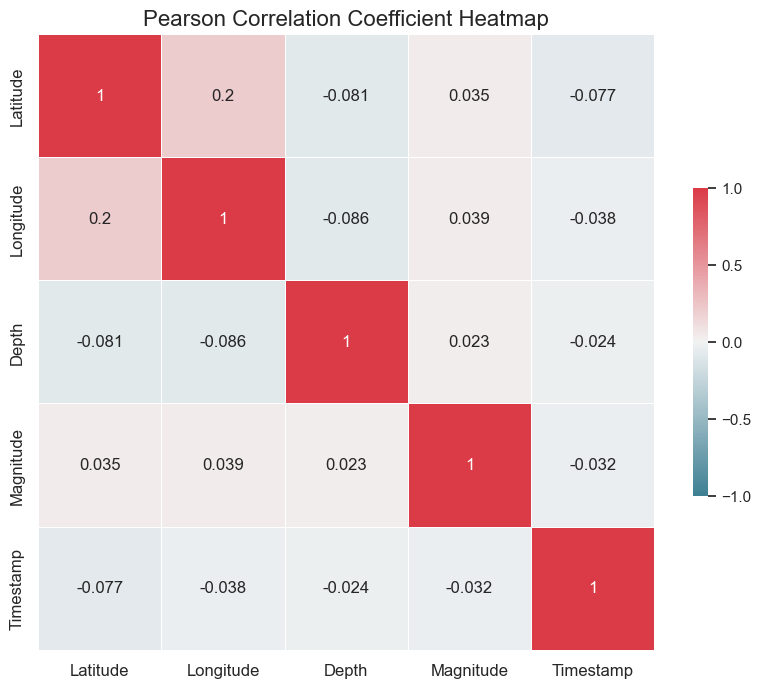

In [210]:
# Assuming 'earthquake_data' is your DataFrame and it has the numerical features you want to correlate
# Calculate the correlation matrix
corr = earthquake_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Define a list of ticks that you want to display on the color bar
color_bar_ticks = [-1, -0.5, 0, 0.5, 1]

# Draw the heatmap with the mask and correct aspect ratio
sns_heatmap = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5, "ticks": color_bar_ticks}, annot=True)

# Set the title with a larger font size
plt.title('Pearson Correlation Coefficient Heatmap', fontsize=16)

# Increase the font size of the x and y labels
sns_heatmap.set_xticklabels(sns_heatmap.get_xticklabels(), fontsize=12)
sns_heatmap.set_yticklabels(sns_heatmap.get_yticklabels(), fontsize=12)

# Show the plot
plt.show()

In [30]:
# Print the best hyperparameters for SVM after tuning
print("Best Hyperparameters for SVM:", svm_model_random_tuned.best_params_)

Best Hyperparameters for SVM: {'kernel': 'linear', 'C': 10}


In [162]:
# Define RGBA color palette
colors = [(166/255, 216/255, 83/255, 1),  # rgba(166,216,83,255)
          (231/255, 138/255, 195/255, 1),  # rgba(231,138,195,255)
          (142/255, 160/255, 203/255, 1)]  # rgba(142,160,203,255)

In [58]:
# Feature names
feature_names = X.columns

In [164]:
# Define outline color and width
outline_color = 'black'
outline_width = 1

In [106]:
# Get feature importances from the model
feature_importances = lgb_classifier.feature_importances_

# Create a pandas series with feature importances and index as feature names
feature_importances_series = pd.Series(feature_importances, index=X_train_lgb.columns)

# Sort the features by importance
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)


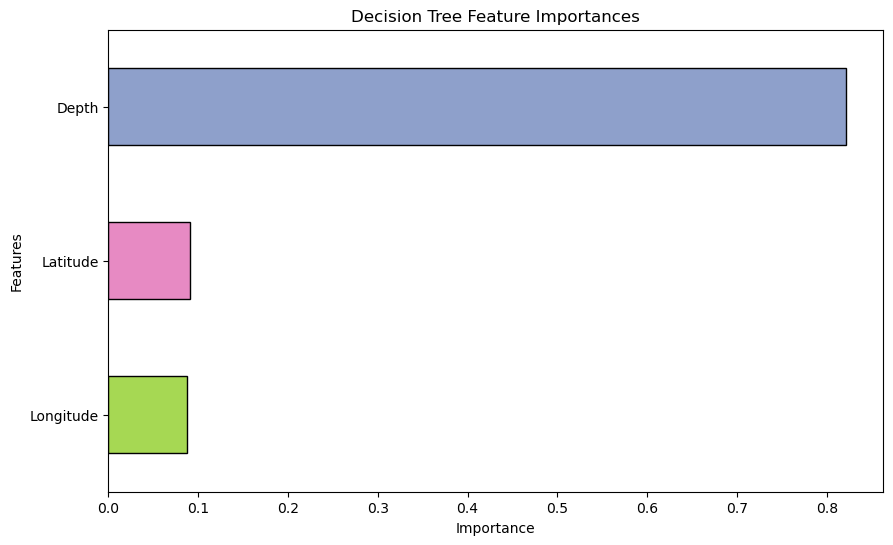

In [165]:
# Plot Decision Tree feature importances
dt_importances = pd.Series(dt_model.feature_importances_, index=feature_names).sort_values()
plt.figure(figsize=(10, 6))
dt_importances.plot(kind='barh', color=colors, edgecolor=outline_color, linewidth=outline_width, title='Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

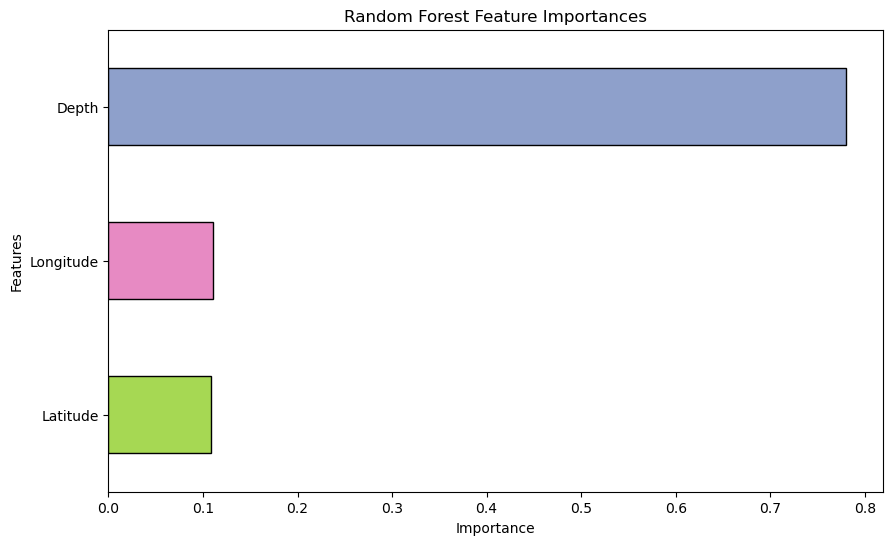

In [166]:
# Plot Random Forest feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values()
plt.figure(figsize=(10, 6))
rf_importances.plot(kind='barh', color=colors, edgecolor=outline_color, linewidth=outline_width, title='Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

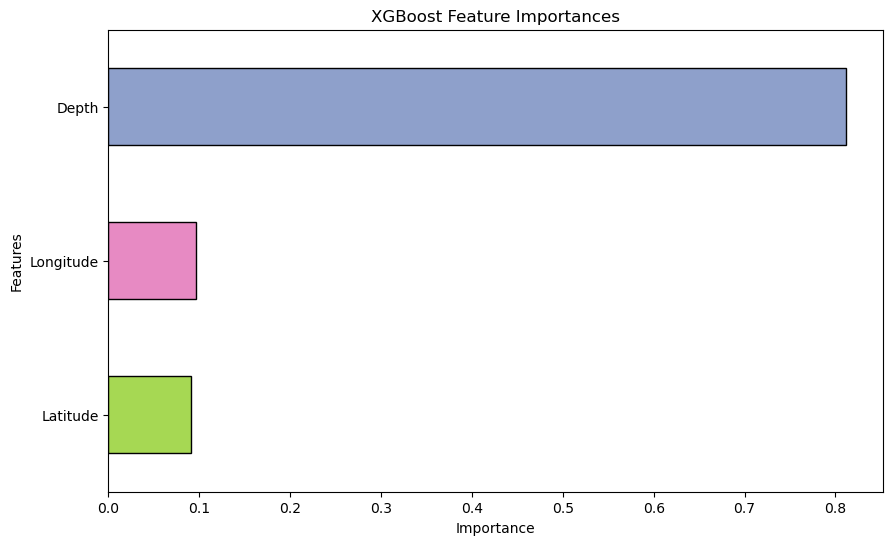

In [167]:
# Plot XGBoost feature importances
xgb_importances = pd.Series(model_xgb.feature_importances_, index=feature_names).sort_values()
plt.figure(figsize=(10, 6))
xgb_importances.plot(kind='barh', color=colors, edgecolor=outline_color, linewidth=outline_width, title='XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

(array([0, 1, 2]),
 [Text(0, 0, 'Latitude'), Text(0, 1, 'Depth'), Text(0, 2, 'Longitude')])

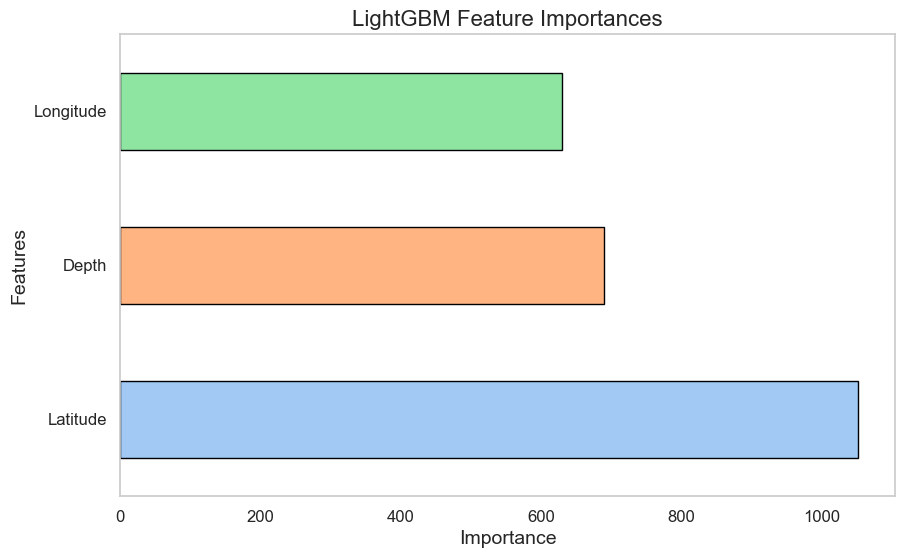

In [205]:
# Plot LightGBM feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='barh', color=colors, edgecolor=outline_color, linewidth=outline_width)

# Set the title and labels with larger font sizes
plt.title('LightGBM Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Increase the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


In [11]:
# Assuming X contains features for unsupervised learning
X_unsupervised = earthquake_data[['Longitude', 'Latitude', 'Depth', 'Magnitude', 'Location Type']].copy()

# Convert categorical features to numerical using one-hot encoding
X_unsupervised = pd.get_dummies(X_unsupervised, columns=['Location Type'])


In [12]:
# Apply K-means clustering
# Adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
earthquake_data['Cluster'] = kmeans.fit_predict(X_unsupervised)

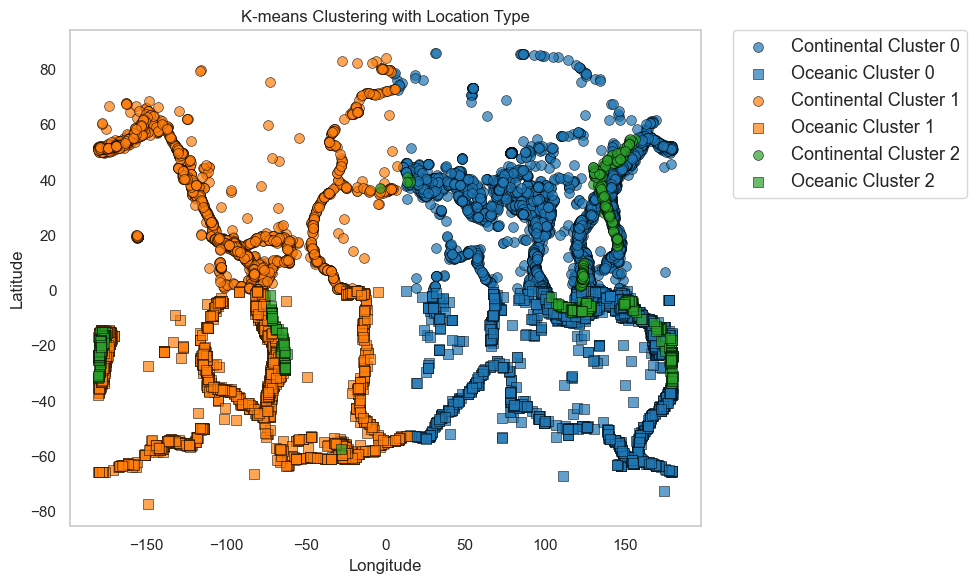

In [213]:
# Assuming 'Cluster' and 'Location Type' are columns in your dataframe
# Make sure 'Cluster' is treated as a categorical variable
earthquake_data['Cluster'] = earthquake_data['Cluster'].astype('category')

# Create the plot
plt.figure(figsize=(10, 6))

# Define marker styles based on Location Type
marker_styles = {'Continental': 'o', 'Oceanic': 's'}

# Loop through the clusters and plot each separately
for cluster in earthquake_data['Cluster'].cat.categories:
    cluster_subset = earthquake_data[earthquake_data['Cluster'] == cluster]
    for location_type in marker_styles:
        subset = cluster_subset[cluster_subset['Location Type'] == location_type]
        plt.scatter(
            subset['Longitude'], subset['Latitude'],
            s=50, alpha=0.7,
            edgecolors='black',  # This will create a black outline around the markers
            linewidth=0.5,  # This specifies the thickness of the outline
            c=[plt.cm.tab10.colors[int(cluster)]],  # Use tab10 colormap for up to 10 clusters
            marker=marker_styles[location_type],
            label=f"{location_type} Cluster {int(cluster)}"
        )

# Add legend outside the plot to the right with larger font size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=13)

# Set title and labels
plt.title('K-means Clustering with Location Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()

In [26]:
# Make sure 'Date' column is in datetime format
earthquake_data['Date'] = pd.to_datetime(earthquake_data['Date'], errors='coerce')

# Drop any NaT values that may have resulted from conversion errors
earthquake_data.dropna(subset=['Date'], inplace=True)

In [27]:
# Create a graph
geo_G = nx.Graph()

In [28]:
# Add nodes with index as the identifier, and position as latitude, longitude tuple
for idx, row in earthquake_data.iterrows():
    geo_G.add_node(idx, pos=(row['Longitude'], row['Latitude']), date=row['Date'])

# Group data by day for creating edges
grouped = earthquake_data.groupby(earthquake_data['Date'].dt.date)

# Add edges within each group that share the same day
for _, group in grouped:
    for u, v in combinations(group.index, 2):
        geo_G.add_edge(u, v)

In [29]:
# Now, check the number of nodes and edges in the graph
print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The graph has 23412 nodes and 764956 edges.


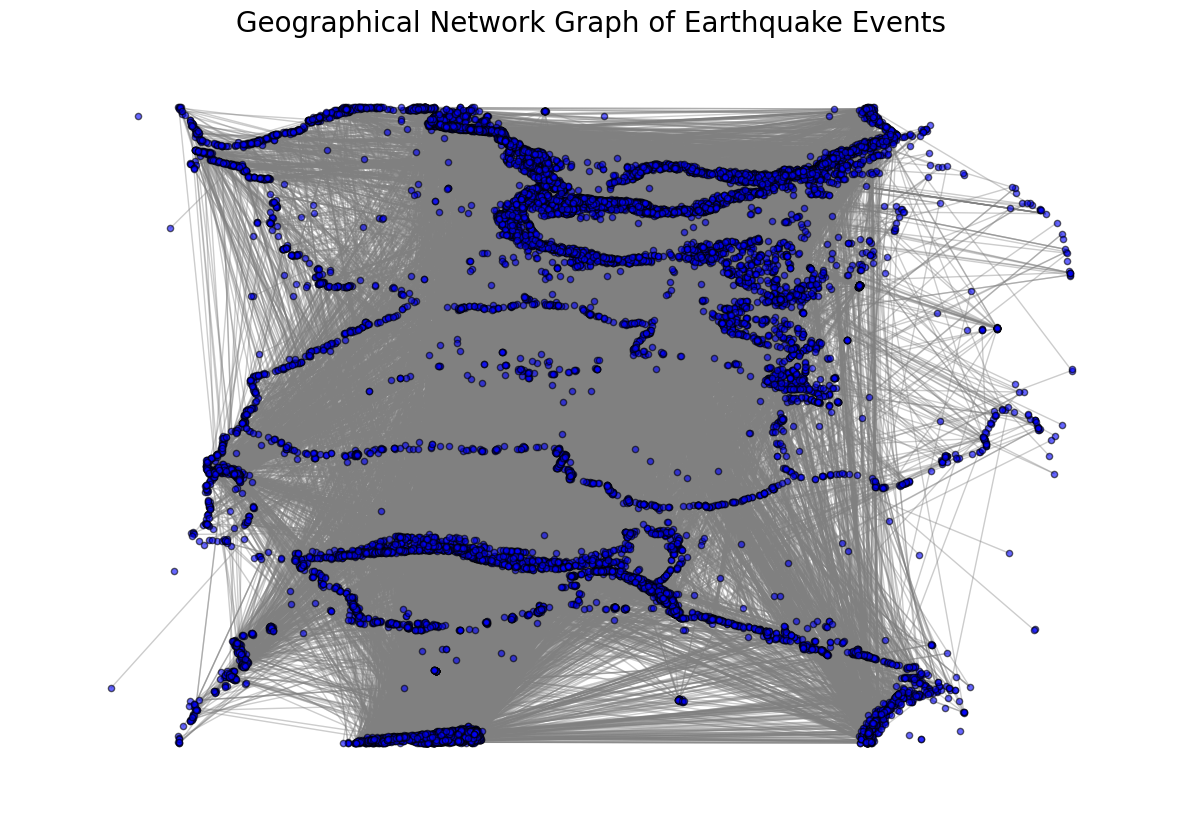

In [141]:
# Now, draw the graph using geographical positions
plt.figure(figsize=(15, 10))  # Set the size of the figure

# Get the positions from the node attributes in the graph
pos = {node: (data['pos'][1], data['pos'][0]) for node, data in geo_G.nodes(data=True)}

# Draw the nodes using the positions
nx.draw_networkx_nodes(geo_G, pos, node_size=20, node_color='blue', alpha=0.6, edgecolors='k')

# Draw the edges using the same positions
nx.draw_networkx_edges(geo_G, pos, alpha=0.4, edge_color='gray')

# Set the title and labels
plt.title('Geographical Network Graph of Earthquake Events', size=20)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)

# Remove the axis for a cleaner look
plt.axis('off')

# Show the plot
plt.show()

In [90]:
# Use a different layout algorithm for better positioning
pos = nx.spring_layout(filtered_G, seed=42)
# Print the layout information
print("Node positions in layout:")
print(pos)

Node positions in layout:
{0: array([-0.51280379, -0.04516488]), 1: array([-0.22868685,  0.30160668]), 2: array([-0.65130907,  0.25000596]), 3: array([-0.26894763,  0.36159369]), 4: array([-0.27892163, -0.07508273]), 5: array([-0.52577394,  0.33042908]), 6: array([-0.56738305,  0.25234506]), 7: array([-0.65433842,  0.13457745]), 8: array([-0.27631414,  0.31383064]), 9: array([-0.32326573,  0.28615341]), 10: array([-0.36406335,  0.28879407]), 11: array([-0.6556173 ,  0.24116264]), 12: array([-0.6253916 , -0.02116054]), 13: array([0.18943134, 0.00362003]), 14: array([ 0.74482256, -0.3831864 ]), 15: array([ 0.32913154, -0.16040373]), 16: array([ 0.71751225, -0.36328503]), 17: array([ 0.60197592, -0.2898522 ]), 18: array([ 0.68620563, -0.34448221]), 19: array([ 0.58073664, -0.27442485]), 20: array([ 0.5700289 , -0.26648524]), 21: array([ 0.4056735 , -0.13145696]), 22: array([ 0.21658416, -0.08004589]), 23: array([ 0.59775174, -0.28682911]), 24: array([ 0.30014852, -0.14111693]), 25: array(

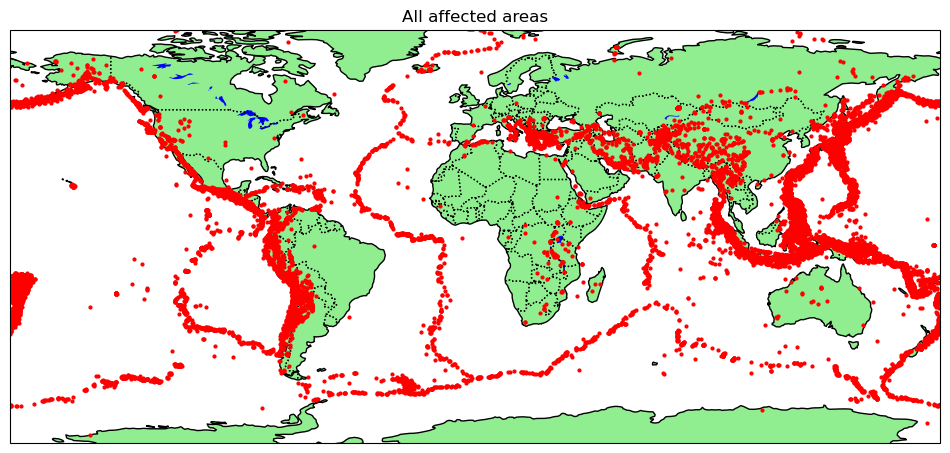

In [60]:
# Create a map using Cartopy, which is designed for geospatial data plotting
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map
ax.set_extent([-180, 180, -80, 80])

# Convert longitudes and latitudes to NumPy arrays
longitudes = earthquake_data["Longitude"].astype(float)
latitudes = earthquake_data["Latitude"].astype(float)

# Convert longitudes and latitudes to map coordinates
xy = ax.projection.transform_points(ccrs.PlateCarree(), longitudes, latitudes)
x, y = xy[:, 0], xy[:, 1]

# Plot your data points
ax.plot(x, y, 'o', markersize=2, color='red')

# Draw map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.add_feature(cfeature.LAKES, facecolor='blue')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Show the map
plt.title("All affected areas")
plt.show()

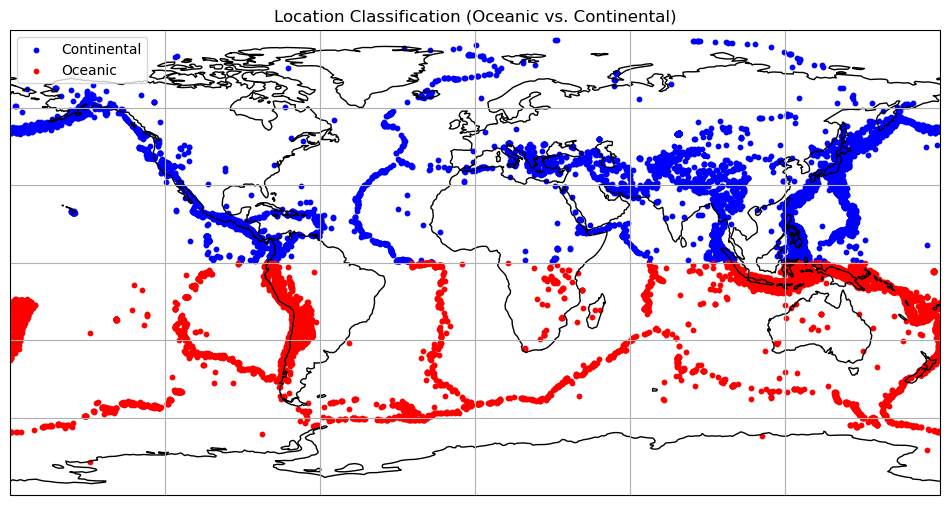

In [61]:
# Create a map visualization
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])

# Plot earthquake locations with different colors based on Location Type
for location_type, group in earthquake_data.groupby('Location Type'):
    color = 'blue' if location_type == 'Continental' else 'red'  # Adjust colors as needed
    ax.scatter(group['Longitude'], group['Latitude'], label=location_type, color=color, s=10)

# Add legend and title
ax.legend()
ax.set_title('Location Classification (Oceanic vs. Continental)')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

plt.show()

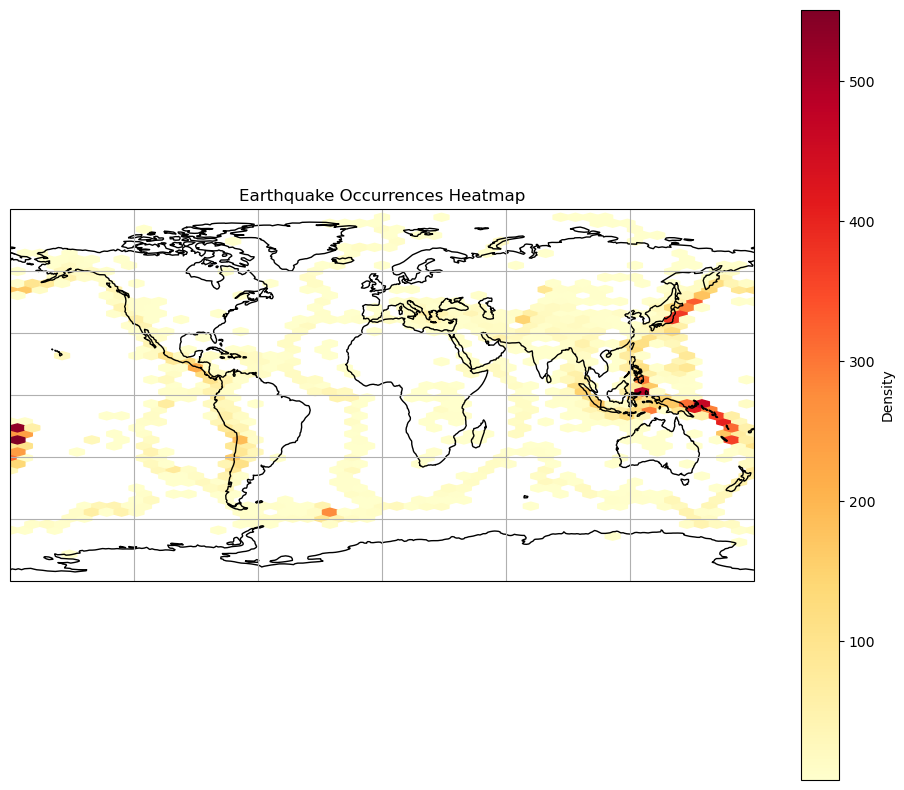

In [62]:
# Create a map visualization with a heatmap
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])

# Plot a heatmap of earthquake occurrences using hexbin
hb = ax.hexbin(
    earthquake_data['Longitude'],
    earthquake_data['Latitude'],
    gridsize=50,  # Adjust gridsize as needed
    cmap='YlOrRd',  # Choose a colormap
    mincnt=1,  # Minimum count for a bin to be colored
)
   
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add a colorbar
cbar = plt.colorbar(hb, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Density')

# Add a title
ax.set_title('Earthquake Occurrences Heatmap')

plt.show()

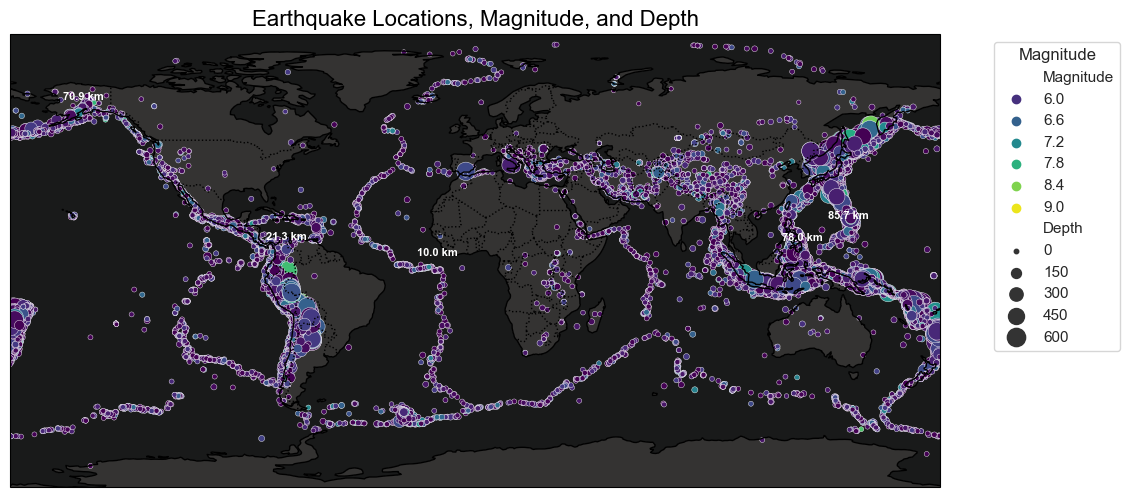

In [63]:
# Define the desired RGB values for colors
ocean_color = (25/255, 26/255, 26/255)  # RGB for #191a1a
land_color = (52/255, 51/255, 50/255)   # RGB for #343332

# Filter out missing values in relevant columns
filtered_earthquake_data = earthquake_data.dropna(subset=['Longitude', 'Latitude', 'Magnitude', 'Time of Day or Season'])

# Set up the plot with Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with color-coded magnitude and size-coded depth
scatter = sns.scatterplot(
    x='Longitude', y='Latitude',
    hue='Magnitude', size='Depth',
    sizes=(10, 200), palette='viridis',
    data=filtered_earthquake_data,
    ax=ax
)

# Customize facecolors of land and ocean features
ax.add_feature(cfeature.LAND, facecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color)

# Draw map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Annotate a subset of points with their depth values
depth_annotation_subset = filtered_earthquake_data.sample(n=5)  # Change 5 to the desired number
for idx, row in depth_annotation_subset.iterrows():
    ax.annotate(f"{row['Depth']} km", (row['Longitude'], row['Latitude']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='white', fontweight='bold')

# Adjust plot aesthetics
plt.title('Earthquake Locations, Magnitude, and Depth', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Magnitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

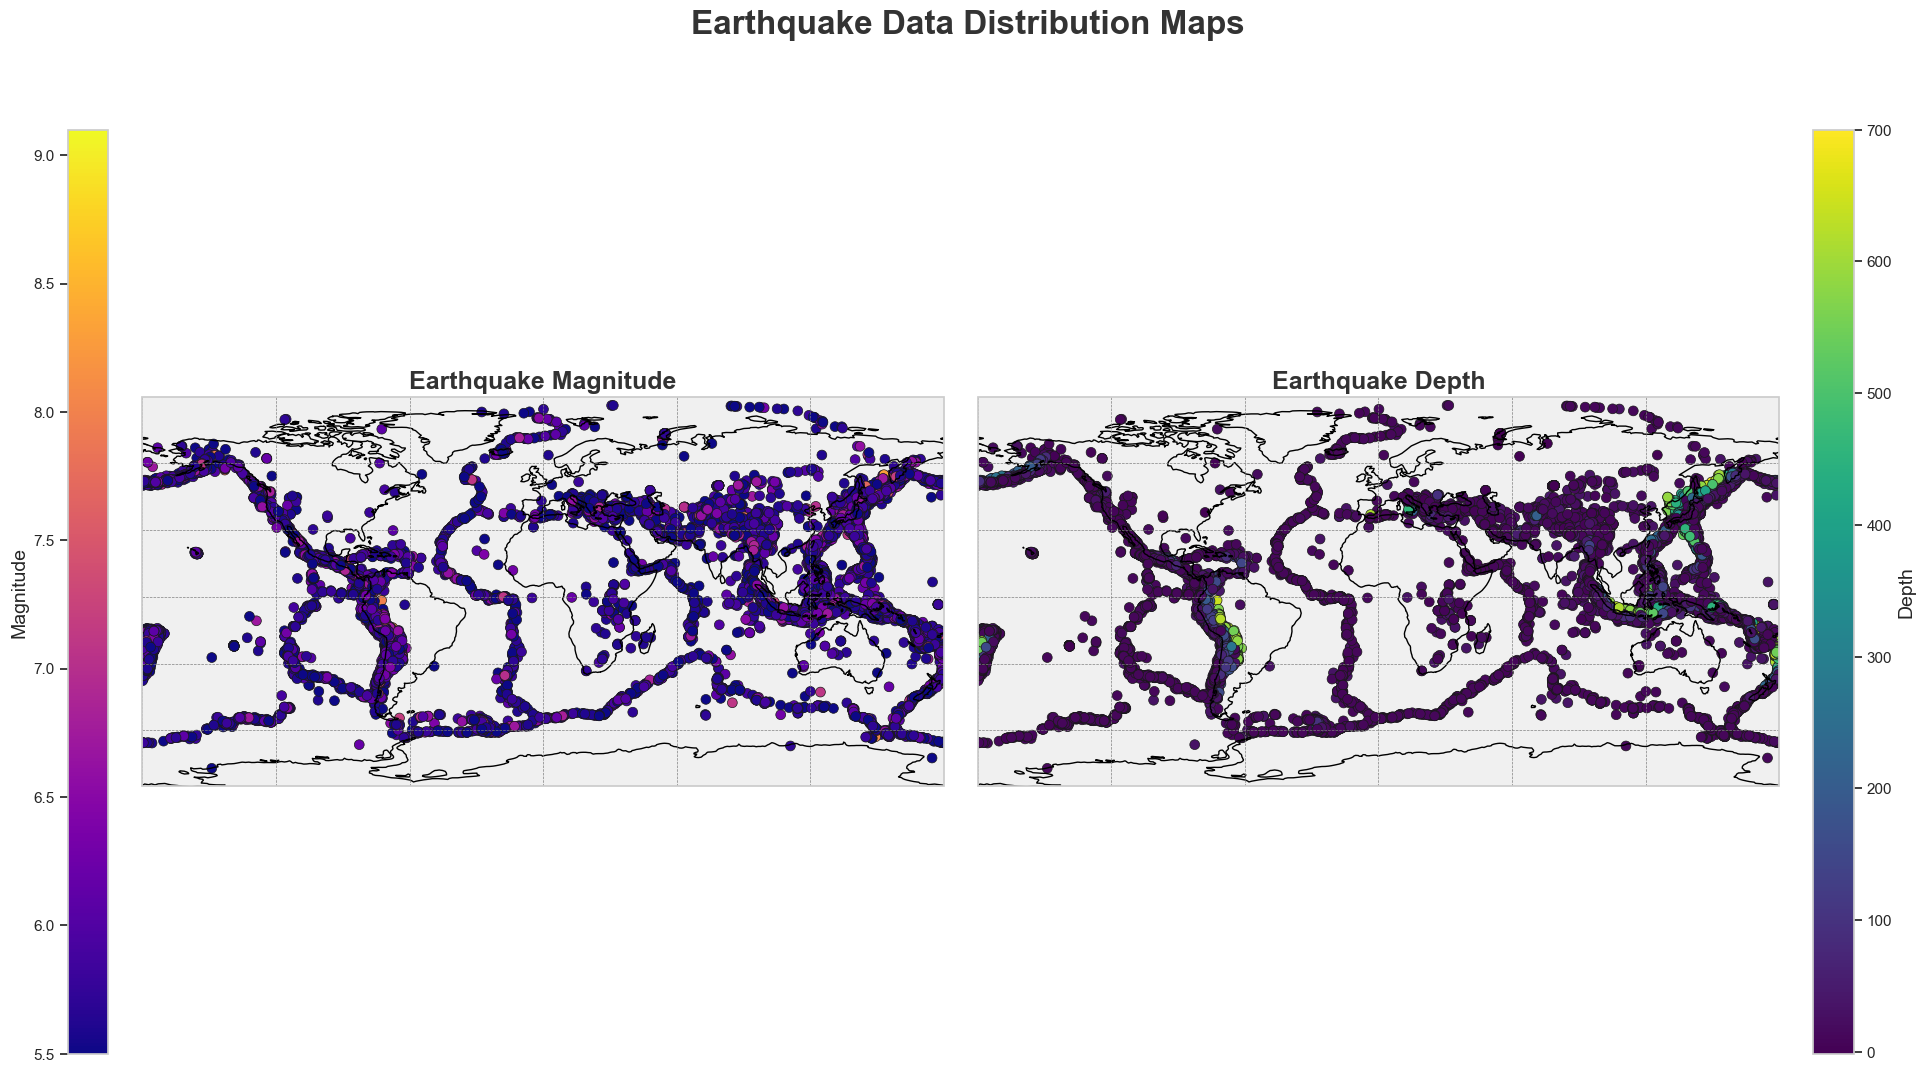

In [64]:

# Set up the plot with Cartopy
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(1, 5, width_ratios=[0.05, 1, 1, 0.05, 0.05], wspace=0.1)

# Scatter plot with color-coded magnitude
ax_magnitude = plt.subplot(gs[1], projection=ccrs.PlateCarree())
scatter_magnitude = ax_magnitude.scatter(
    filtered_earthquake_data['Longitude'], filtered_earthquake_data['Latitude'],
    c=filtered_earthquake_data['Magnitude'], s=50, cmap='plasma', edgecolors='k', linewidth=0.5,
    transform=ccrs.PlateCarree()
)
# Customize the magnitude scatter plot subplot
ax_magnitude.coastlines() # Add coastlines for geographic reference
ax_magnitude.gridlines(color='gray', linestyle='--', linewidth=0.5) # Add gridlines for geographic reference
ax_magnitude.set_facecolor('#f0f0f0')  # Light gray background
ax_magnitude.set_title('Earthquake Magnitude', fontsize=18, fontweight='bold', color='#333333')
ax_magnitude.set_xlabel('Longitude', fontsize=14)
ax_magnitude.set_ylabel('Latitude', fontsize=14)

# Add colorbar on the left for magnitude
cax_magnitude = plt.subplot(gs[0])
cbar_magnitude = plt.colorbar(scatter_magnitude, cax=cax_magnitude, orientation='vertical')
cbar_magnitude.set_label('Magnitude', fontsize=14)

# Move the colorbar to the left side
cax_magnitude.yaxis.set_ticks_position('left')
cax_magnitude.yaxis.set_label_position('left')

# Scatter plot with color-coded depth
ax_depth = plt.subplot(gs[2], projection=ccrs.PlateCarree())
scatter_depth = ax_depth.scatter(
    filtered_earthquake_data['Longitude'], filtered_earthquake_data['Latitude'],
    c=filtered_earthquake_data['Depth'], s=50, cmap='viridis', edgecolors='k', linewidth=0.5,
    transform=ccrs.PlateCarree()
)
# Customize the depth scatter plot subplot
ax_depth.coastlines() # Add coastlines for geographic reference
ax_depth.gridlines(color='gray', linestyle='--', linewidth=0.5) # Add gridlines for geographic reference
ax_depth.set_facecolor('#f0f0f0')  # Light gray background
ax_depth.set_title('Earthquake Depth', fontsize=18, fontweight='bold', color='#333333')
ax_depth.set_xlabel('Longitude', fontsize=14)
ax_depth.set_ylabel('Latitude', fontsize=14)

# Add colorbar on the right for depth
cax_depth = plt.subplot(gs[3])
cbar_depth = plt.colorbar(scatter_depth, cax=cax_depth, orientation='vertical')
cbar_depth.set_label('Depth', fontsize=14)

# Overall title for the entire set of maps
fig.suptitle('Earthquake Data Distribution Maps', fontsize=24, fontweight='bold', color='#333333')

# Show the plot
plt.show()

In [65]:
# Filter out missing values in relevant columns
filtered_earthquake_data = earthquake_data.dropna(subset=['Longitude', 'Latitude', 'Magnitude', 'Time of Day or Season'])

# Create an interactive map using Folium
map_center = [filtered_earthquake_data['Latitude'].mean(), filtered_earthquake_data['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=3, control_scale=True)

# Create a MarkerCluster for better performance with a large number of markers
marker_cluster = MarkerCluster().add_to(mymap)

# Add earthquake data as markers to the map
for idx, row in filtered_earthquake_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Magnitude'] * 2,
        color=sns.color_palette("viridis", as_cmap=True)(row['Magnitude'] / 10),
        fill=True,
        fill_color=sns.color_palette("viridis", as_cmap=True)(row['Magnitude'] / 10),
        fill_opacity=0.7,
        tooltip=f"Magnitude: {row['Magnitude']}, Depth: {row['Depth']}",
    ).add_to(marker_cluster)

# Display the map
mymap.save('earthquake_map.html')

In [71]:
# Display the map in the notebook
IFrame(src='earthquake_map.html', width=800, height=700)

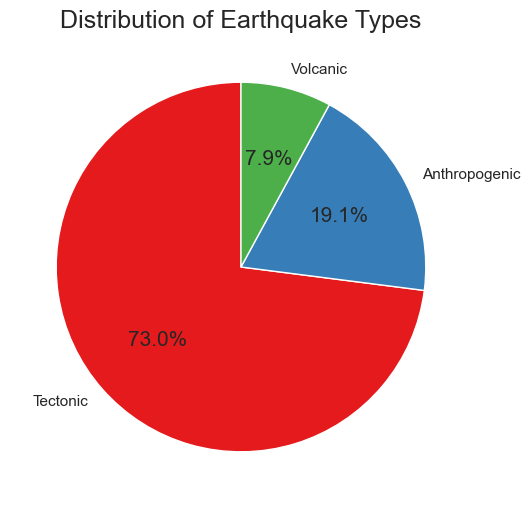

In [219]:
# Assuming earthquake_data has a column 'Earthquake Type'
# Count the occurrences of each earthquake type
earthquake_type_counts = earthquake_data['Earthquake Type'].value_counts()

# Set the style of Seaborn
sns.set(style="whitegrid")

# Create a pie chart with larger labels
plt.figure(figsize=(10, 6))
_, _, autotexts = plt.pie(
    earthquake_type_counts,
    labels=earthquake_type_counts.index,
    autopct='%1.1f%%',  # Display percentage on each slice
    startangle=90,  # Start the pie chart at 90 degrees (top of the circle)
    colors=sns.color_palette('Set1')  # You can choose a different color palette
)

# Set plot title with a larger font size
plt.title('Distribution of Earthquake Types', fontsize=18)

# Increase label font size for the percentages within the pie slices
for autotext in autotexts:
    autotext.set_size(15)

# Show the plot
plt.show()

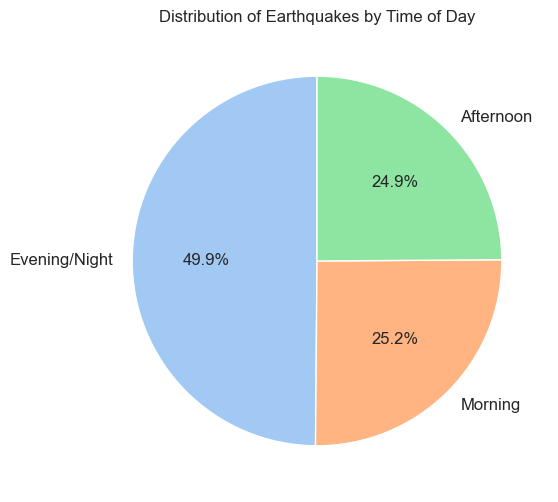

In [183]:
# Assuming earthquake_data has a column 'Time of Day or Season'
# Count the occurrences of each time category
time_counts = earthquake_data['Time of Day or Season'].value_counts()

# Set a custom color palette
colors = sns.color_palette("pastel")

# Set the style of Seaborn
sns.set(style="whitegrid")

# Plot the pie chart with style
plt.figure(figsize=(10, 6))
pie_chart = plt.pie(
    time_counts, 
    labels=time_counts.index, 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=90,
    textprops={'fontsize': 12}  # Adjust fontsize for the labels
)

# Set plot title
plt.title('Distribution of Earthquakes by Time of Day')

# Show the plot
plt.show()


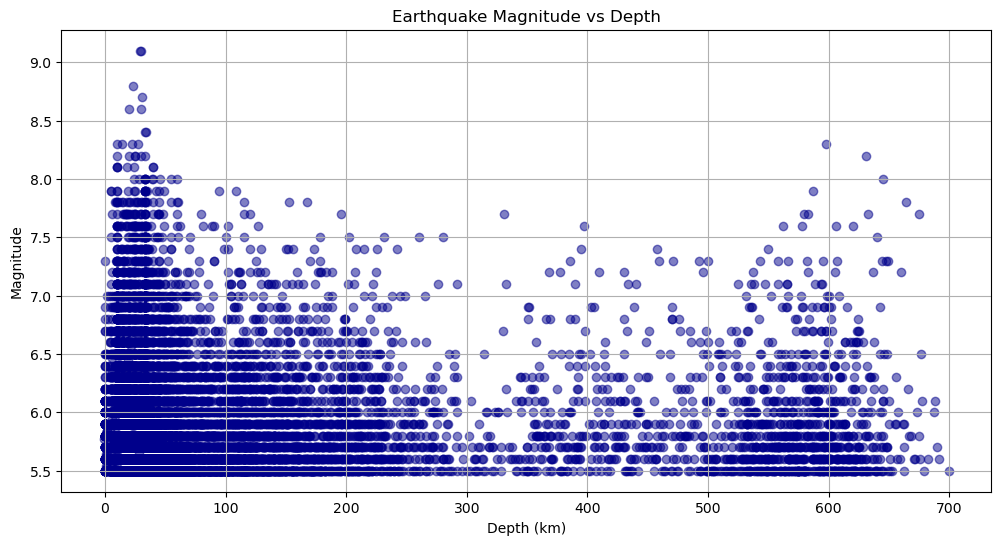

In [145]:
# Assuming 'Depth' is the depth of the earthquake and 'Magnitude' is its magnitude
plt.figure(figsize=(12, 6))
plt.scatter(earthquake_data['Depth'], earthquake_data['Magnitude'], alpha=0.5, c='darkblue')
plt.title('Earthquake Magnitude vs Depth')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()